# Week 7
## Decision Tree

Decision trees are one of the easiest machine learning, prediction methods to explain, apply and interogate.  In addition, understanding decision tree-based prediction is a prerequisite to more complicated and powerful methods such as random forest and tree-based bagging and boosting.  For this demonstration we use a 1,000 well with 7 variable unconventional dataset.<br>
This dataset includes 6 predictors (features) and 1 response.  We take this multivariate dataset and only retain the three variables (2 predictors and 1 response) for a simple demonstration of the decision tree method. We break the data set into 500 training data and 500 testing data.<br>

#### What is a decision tree?

1. method for supervised learning
2. categorical prediction with a classification tree and continuous prediction with a regression tree
3. fundamental idea is to divide feature space into exhastive, mutually exclusive regions (terminal or leaf nodes in the tree)
4. estimate with the average of data in each region for continuous prediction or the majority category for the data in each region for categorical prediction
5. segment the feature space with hierarchical, binary splitting that may be respresented as a decision tree
6. apply a greedy method to find the sequential splits for any feature that minimizes the residual sum of squares

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plots
import seaborn as sns ## generates enhanced plots
from math import sqrt
import math                                               # basic calculations like square root
import os                                                 # to set current working directory 
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz                  # graphical visualization of trees
from sklearn.preprocessing import StandardScaler          # standardize variables to mean of 0.0 and variance of 1.0
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from subprocess import check_call

In [2]:
# Declare functions
#Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model. 
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_tree(tree,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.show()
    
def check_tree(tree,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = tree.predict(np.c_[xfeature,yfeature])
    plt.figure(figsize=(6,6))
    plt.scatter(response,predict_train,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    plt.show()
    MSE = metrics.mean_squared_error(mydata_3var["Production"],predict_train)
    Var_Explained = metrics.explained_variance_score(mydata_3var["Production"],predict_train)
    cor = math.sqrt(metrics.r2_score(mydata_3var["Production"],predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Varianace Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def tree_to_code(tree, feature_names):                    # code from StackOverFlow by paulkernfeld
    tree_ = tree.tree_                                    # convert tree object to portable code to use anywhere
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1) 
    
def get_lineage(tree, feature_names):                     # code from StackOverFlow by Zelanzny7
    left      = tree.tree_.children_left                  # track the decision path for any set of inputs
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:,0]     
    def recurse(left, right, child, lineage=None):          
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        lineage.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)
    for child in idx:
        for node in recurse(left, right, child):
            print(node) 
            

# Define an evaluation function for calculating some helpful metrics
# We can calculate the mean square error and the square root of the MSE for our prediction model.

def evaluate (model, test_features, test_labels):
    predictions=model.predict(test_features)
    r2=r2_score(y_pred=predictions, y_true=test_labels)
    MAE=mean_absolute_error(test_labels, predictions)
    MSE=mean_squared_error(test_labels, predictions)
    rmse = sqrt(MSE)

    print('r2 = {:0.2f}'.format(r2))
    print('MAE = {:0.2f}'.format(MAE))
    print('Mean Square Error = {:0.2f}'.format(MSE))
    print('Squareroot Mean Square Error = {:0.2f}'.format(rmse))

In [3]:
# Read the data table from unconv_MV_v2.csv using pandas
mydata = pd.read_csv("Lecture7_unconv_MV_v2.csv")

In [4]:
# Let's visualize the first several rows of our data so we can make sure we successfully loaded it
mydata.head()

Sample    Por  LogPerm    AI  Brittle   TOC    VR   Production  Prod2Scaled
0       1  15.91     1.67  3.06    14.05  1.36  1.85   177.381958  1897.657798
1       2  15.34     1.65  2.60    31.88  1.37  1.79  1479.767778  2745.732996
2       3  20.45     2.02  3.13    63.67  1.79  2.53  4421.221583  5835.130524
3       4  11.95     1.14  3.90    58.81  0.40  2.03  1488.317629  2132.237219
4       5  19.53     1.83  2.57    43.75  1.40  2.11  5261.094919  6282.254735

In [5]:
#Let's remove the well index
mydata = mydata.iloc[:,1:9]                             # copy all rows and columns 1 through 8, note 0 column is removed

In [6]:
# Let's visualize the last several rows of our data so we can make sure we successfully loaded it
mydata.tail()

Por  LogPerm    AI  Brittle   TOC    VR   Production  Prod2Scaled
995  17.99     2.29  3.38    44.32  0.98  2.08  4211.527806  5230.433447
996  12.12     0.82  3.52    57.07 -0.04  1.73  1560.333735  2216.536779
997  15.55     1.50  2.48    58.25  1.89  2.35  2858.180459  3793.873108
998  20.89     2.02  3.23    46.17  1.71  2.27  6934.576348  7754.889551
999  15.74     1.31  2.37    73.08  1.24  2.06   963.675793  2441.880802

In [7]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Por          1000 non-null   float64
 1   LogPerm      1000 non-null   float64
 2   AI           1000 non-null   float64
 3   Brittle      1000 non-null   float64
 4   TOC          1000 non-null   float64
 5   VR           1000 non-null   float64
 6   Production   1000 non-null   float64
 7   Prod2Scaled  1000 non-null   float64
dtypes: float64(8)
memory usage: 62.6 KB


In [8]:
#check the summary summary statistics.
mydata.describe()

Por      LogPerm           AI      Brittle          TOC  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     14.950460     1.398880     2.982610    49.769980     1.003810   
std       3.029634     0.405966     0.577629    14.944955     0.504978   
min       5.400000     0.120000     0.960000     3.030000    -0.260000   
25%      12.857500     1.130000     2.577500    39.722500     0.640000   
50%      14.985000     1.390000     3.010000    49.680000     0.995000   
75%      17.080000     1.680000     3.360000    59.170000     1.360000   
max      24.650000     2.580000     4.700000    93.470000     2.710000   

                VR    Production   Prod2Scaled  
count  1000.000000   1000.000000   1000.000000  
mean      1.991170   2247.295809   3237.154325  
std       0.308194   1464.256312   1507.552730  
min       0.900000      2.713535      2.713535  
25%       1.810000   1191.369560   2120.961071  
50%       2.000000   1976.487820   2991.762748  
75%       2.172500   3023.594214   4105.623405  
max       2.900000  12568.644130  12568.644130

It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. <br>
This is physically imposible.  These values must be an error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  <br>
We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [9]:
num = mydata._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
mydata.describe()                           # calculate summary statistics for the data

Por      LogPerm           AI      Brittle          TOC  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     14.950460     1.398880     2.982610    49.769980     1.006170   
std       3.029634     0.405966     0.577629    14.944955     0.499838   
min       5.400000     0.120000     0.960000     3.030000     0.000000   
25%      12.857500     1.130000     2.577500    39.722500     0.640000   
50%      14.985000     1.390000     3.010000    49.680000     0.995000   
75%      17.080000     1.680000     3.360000    59.170000     1.360000   
max      24.650000     2.580000     4.700000    93.470000     2.710000   

                VR    Production   Prod2Scaled  
count  1000.000000   1000.000000   1000.000000  
mean      1.991170   2247.295809   3237.154325  
std       0.308194   1464.256312   1507.552730  
min       0.900000      2.713535      2.713535  
25%       1.810000   1191.369560   2120.961071  
50%       2.000000   1976.487820   2991.762748  
75%       2.172500   3023.594214   4105.623405  
max       2.900000  12568.644130  12568.644130

In [10]:
mydata

Por  LogPerm    AI  Brittle   TOC    VR   Production  Prod2Scaled
0    15.91     1.67  3.06    14.05  1.36  1.85   177.381958  1897.657798
1    15.34     1.65  2.60    31.88  1.37  1.79  1479.767778  2745.732996
2    20.45     2.02  3.13    63.67  1.79  2.53  4421.221583  5835.130524
3    11.95     1.14  3.90    58.81  0.40  2.03  1488.317629  2132.237219
4    19.53     1.83  2.57    43.75  1.40  2.11  5261.094919  6282.254735
..     ...      ...   ...      ...   ...   ...          ...          ...
995  17.99     2.29  3.38    44.32  0.98  2.08  4211.527806  5230.433447
996  12.12     0.82  3.52    57.07  0.00  1.73  1560.333735  2216.536779
997  15.55     1.50  2.48    58.25  1.89  2.35  2858.180459  3793.873108
998  20.89     2.02  3.23    46.17  1.71  2.27  6934.576348  7754.889551
999  15.74     1.31  2.37    73.08  1.24  2.06   963.675793  2441.880802

[1000 rows x 8 columns]

In [11]:
# Calculate the correlation matrix 
#For multivariate analysis it is a good idea to check the correlation matrix.
#We can calculate it and view it in the console with these commands.

matrix = mydata.corr()
matrix

Por   LogPerm        AI   Brittle       TOC        VR  \
Por          1.000000  0.807776 -0.505669 -0.247762  0.711912  0.084589   
LogPerm      0.807776  1.000000 -0.324986 -0.144507  0.506516  0.045767   
AI          -0.505669 -0.324986  1.000000  0.162364 -0.547433  0.487492   
Brittle     -0.247762 -0.144507  0.162364  1.000000 -0.238934  0.292687   
TOC          0.711912  0.506516 -0.547433 -0.238934  1.000000  0.306797   
VR           0.084589  0.045767  0.487492  0.292687  0.306797  1.000000   
Production   0.686822  0.568841 -0.326660 -0.077248  0.504018  0.142409   
Prod2Scaled  0.856115  0.701539 -0.418235 -0.146066  0.620180  0.132344   

             Production  Prod2Scaled  
Por            0.686822     0.856115  
LogPerm        0.568841     0.701539  
AI            -0.326660    -0.418235  
Brittle       -0.077248    -0.146066  
TOC            0.504018     0.620180  
VR             0.142409     0.132344  
Production     1.000000     0.963611  
Prod2Scaled    0.963611     1.000000

Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may improve our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

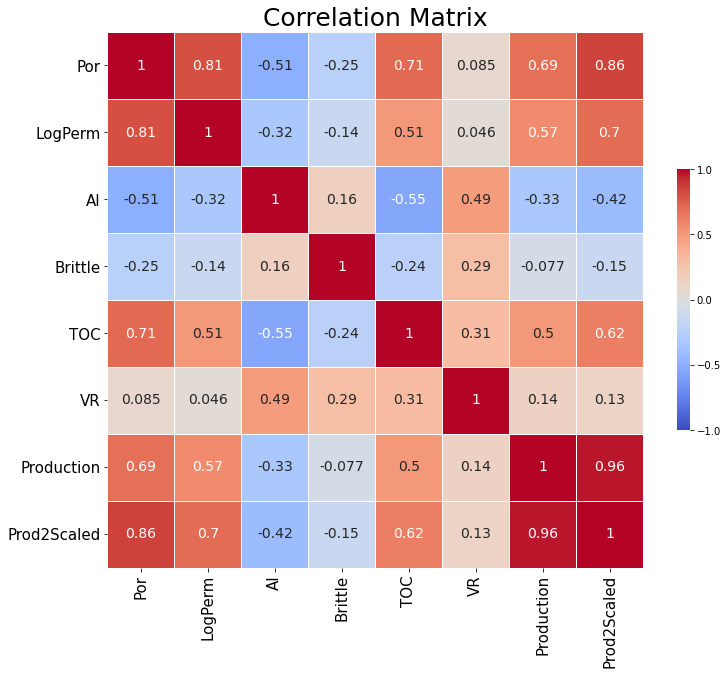

In [12]:
import seaborn as sns
# Let's use create graphical correlation matrix plot
# Create Axis
fig, ax = plt.subplots(figsize=(12, 12))

# Using Seaborn HeatMap
sns.heatmap(matrix,  square = True, linewidths = .8, cbar_kws = {'shrink': .4,  'ticks' : [-1, -.5, 0, 0.5, 1]},
            cmap = 'coolwarm', vmin = -1,  vmax = 1, annot = True, annot_kws = {'size': 14})

# Setting Axis Properties
ax.set_yticklabels(matrix.columns, rotation = 0, size = 15)
ax.set_xticklabels(matrix.columns, rotation = 90, size =15)
ax.set_title("Correlation Matrix", size = 25)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

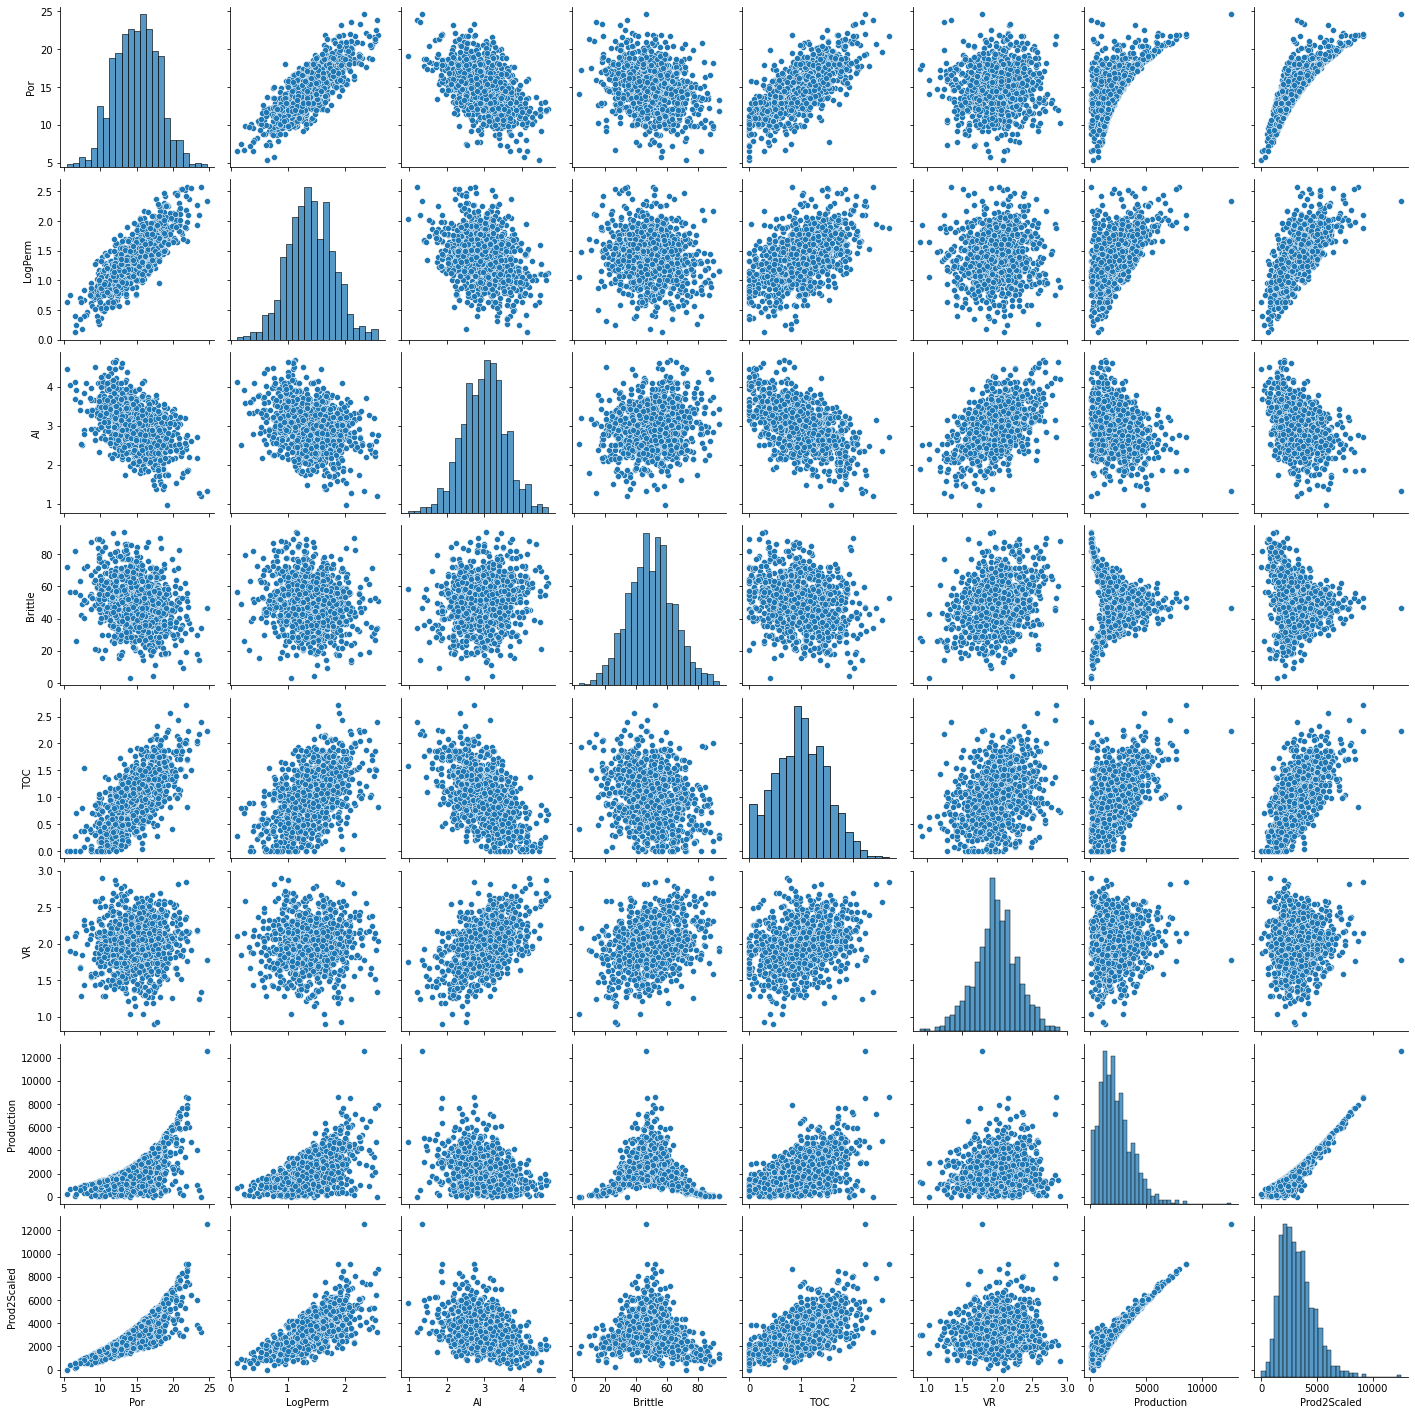

In [13]:
# Now let's view the scatterplot matrices from the seaborn Package 
# create pairplot 
sns.pairplot(mydata)

# to show
plt.show()

In [14]:
# This dataset has varriables from 1,000 unconventional wells including well average porosity, log transform 
# of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%),
# total organic carbon (%), vitrinite reflectance (%), and production (MCFPD)

#### Working with Only Two Features
Let's start simple with a trivariate (3 variable) problem <br>
Let's simplify the problem to 2 features, Porosity and Brittleness to predict Production rate.  By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown compleltely on a single plot).

In [15]:
mydata

Por  LogPerm    AI  Brittle   TOC    VR   Production  Prod2Scaled
0    15.91     1.67  3.06    14.05  1.36  1.85   177.381958  1897.657798
1    15.34     1.65  2.60    31.88  1.37  1.79  1479.767778  2745.732996
2    20.45     2.02  3.13    63.67  1.79  2.53  4421.221583  5835.130524
3    11.95     1.14  3.90    58.81  0.40  2.03  1488.317629  2132.237219
4    19.53     1.83  2.57    43.75  1.40  2.11  5261.094919  6282.254735
..     ...      ...   ...      ...   ...   ...          ...          ...
995  17.99     2.29  3.38    44.32  0.98  2.08  4211.527806  5230.433447
996  12.12     0.82  3.52    57.07  0.00  1.73  1560.333735  2216.536779
997  15.55     1.50  2.48    58.25  1.89  2.35  2858.180459  3793.873108
998  20.89     2.02  3.23    46.17  1.71  2.27  6934.576348  7754.889551
999  15.74     1.31  2.37    73.08  1.24  2.06   963.675793  2441.880802

[1000 rows x 8 columns]

In [16]:
# mydata_por = pd.DataFrame(mydata['Por'])      # extract and rename 3 features from the original dataframe
# mydata_brittle= pd.DataFrame(mydata['Brittle'])   
# mydata_prod = pd.DataFrame(mydata['Prod2Scaled'])
mydata_3var =pd.DataFrame(mydata[['Por','Brittle','Production']])

In [17]:
mydata_3var.head()# check the new dataframe

Por  Brittle   Production
0  15.91    14.05   177.381958
1  15.34    31.88  1479.767778
2  20.45    63.67  4421.221583
3  11.95    58.81  1488.317629
4  19.53    43.75  5261.094919

In [18]:
mydata_3var.describe().transpose()                   # calculate summary statistics for the data

count         mean          std       min         25%  \
Por         1000.0    14.950460     3.029634  5.400000    12.85750   
Brittle     1000.0    49.769980    14.944955  3.030000    39.72250   
Production  1000.0  2247.295809  1464.256312  2.713535  1191.36956   

                   50%          75%          max  
Por           14.98500    17.080000     24.65000  
Brittle       49.68000    59.170000     93.47000  
Production  1976.48782  3023.594214  12568.64413

Let's first check the univariate statistics of Porosity, Brittleness and Producton.

3.0 12569.0


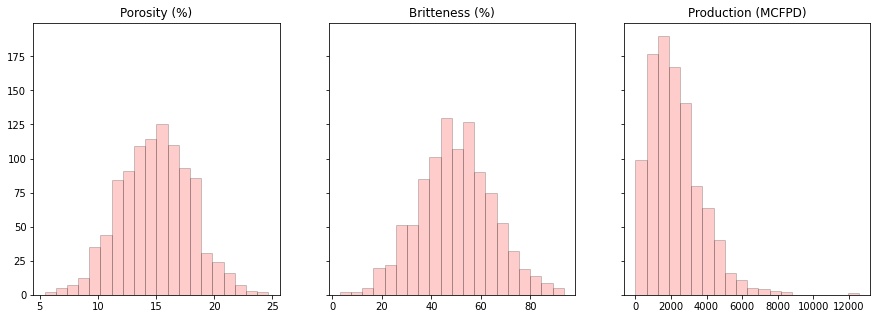

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(15,5))
ax1.hist(mydata_3var["Por"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax1.set_title('Porosity (%)')
ax2.hist(mydata_3var["Brittle"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax2.set_title('Britteness (%)')
ax3.hist(mydata_3var["Production"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax3.set_title('Production (MCFPD)')
prod_min = round(min(mydata_3var["Production"]),0); prod_max = round(max(mydata_3var["Production"]),0)
print(prod_min,prod_max)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  Let's look at a scatter plot of Porosity vs. Brittleness with points colored by Production.

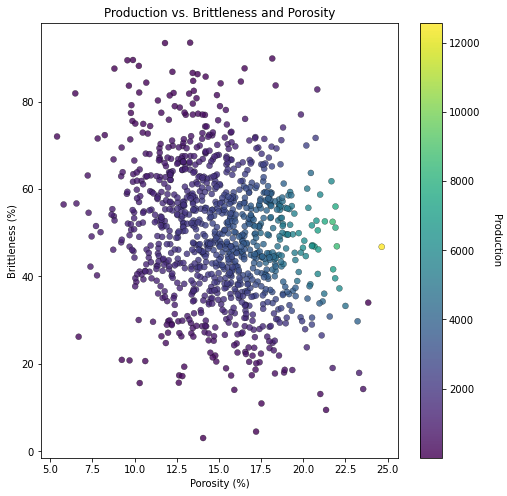

In [20]:
plt.figure(figsize=(8,8))
im = plt.scatter(mydata_3var["Por"],mydata_3var["Brittle"],s=None, c=mydata_3var["Production"], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)
plt.show()

This problem looks complicated and could not be modeled with simple linear regression.  It appears there is a sweet spot for Brittleness and increasing Porosity is always beneficial for Production.

let's check out the production vs. porosity and brittleness

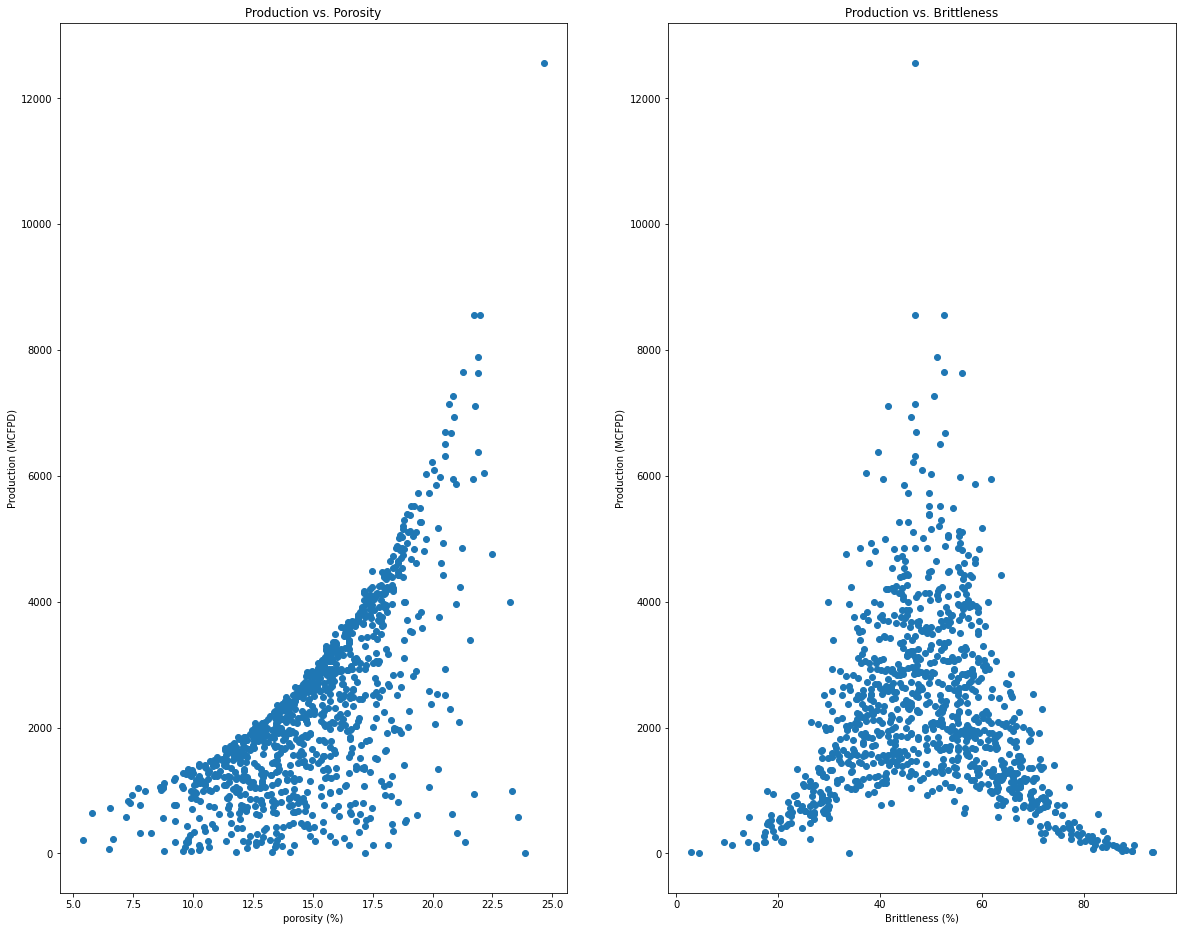

In [21]:
#Let's plot porosity vs. brittleness with production as greyscale
fig, ax = plt.subplots(1,2, figsize=(20, 16))
ax[0].scatter(mydata_3var['Por'], mydata_3var['Production'])
ax[0].set_xlabel("porosity (%)")
ax[0].set_ylabel("Production (MCFPD)")
ax[0].set_title("Production vs. Porosity")

ax[1].scatter(x = mydata_3var['Brittle'], y = mydata_3var['Production'])
ax[1].set_xlabel("Brittleness (%)")
ax[1].set_ylabel("Production (MCFPD)")
ax[1].set_title("Production vs. Brittleness")

plt.show()

#### Calculation of Decision Tree

The input for the decision tree is 2 DataFrames, one with the predictors / features and the other with the response variable.  We will use the DataFrame member function copy() to copy the respective columns to 2 new DataFrames. 

In [22]:
features = mydata_3var[['Por','Brittle']].copy()     # make a new DataFrame with features
response = mydata_3var[['Production']].copy()        # make a new DataFrame with responses

Now we are ready to run the DecisionTreeRegressor command to build our regression tree for Production given Porosity and Brittleness.  We will use our two functions defined above to visualize the decision tree prediction over the feature space and the cross plot of actual and estimated production for the training data along with three model metrics from the sklearn.metric module.

Note, we constrain our tree by limitting it to a maximum depth of 3, only 3 levels of hierarchical spilts and a minimum of 5 data at each terminal node / leaf.

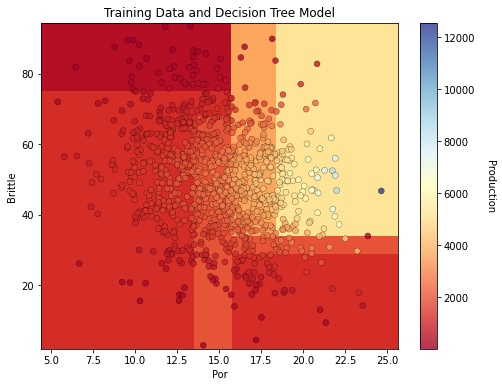

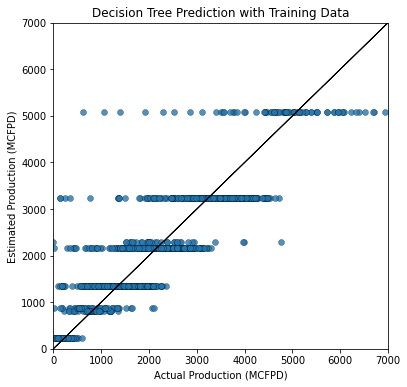

Mean Squared Error on Training =  610129.7 , Varianace Explained = 0.72 Cor = 0.85


In [23]:
my_tree = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth = 3)
my_tree = my_tree.fit(features, response)

visualize_tree(my_tree,mydata_3var["Por"],mydata_3var["Brittle"],mydata_3var["Production"],'Training Data and Decision Tree Model')

check_tree(my_tree,mydata_3var["Por"],mydata_3var["Brittle"],mydata_3var["Production"],'Decision Tree Prediction with Training Data')

See the horizontal lines on the plot of estimated vs. actual production (plot on the bottom)? That is expected as the regression tree estimates with the average of the data in each region of the feature space (terminal node). It looks like 8 terminal nodes / regions in the feature space (2 are almost on top of each other), we can confirm that below when we look at the tree.  In other words, the model solution is binned and has only 8 possible predictions. If we have a more complicated tree with more terminal nodes then there would be more lines.  

As reported above, we described 85% of the variance with this simple tree. The visualization of the estimates over the entire feature space demonstrate the hierarchical binary splitting applied in a decision tree (the plot on the top).

It is useful and instructive to visualize the tree.  There is a nice tree visualizer in the sklearn.tree known as export_graphviz.  Check out the result below.  

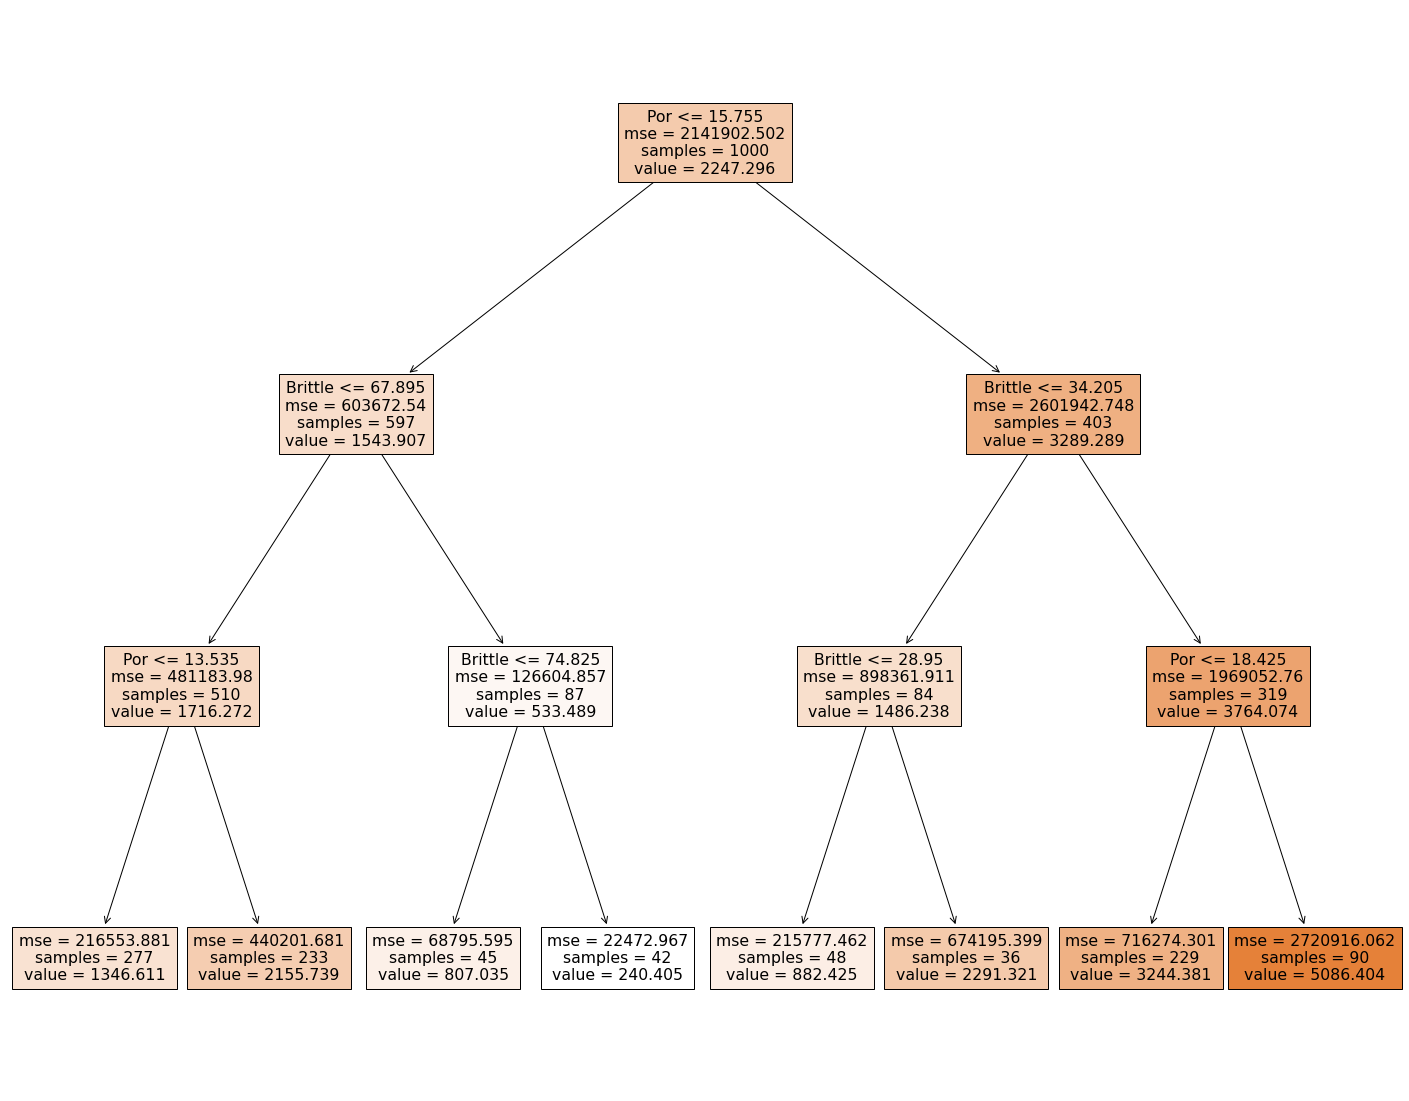

In [24]:
from sklearn import tree
feature_names=['Por','Brittle']

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(my_tree, 
                   feature_names=list(features),  
                   filled=True)

We can confirm that we have a miximum of 3 levels and that we have 8 terminal nodes.  Each represents a region in the feature space.  So for any combination of Porosity and Brittleness we can predict Production with our tree.  All we have to do is start at node 0 at the top and track each decision, go left if true and go right if false.  When we get to a terminal node we have a prediction for production.  Of course, we could trim or "prune" the tree to simplify it.  For example, we could cut off all the terminal nodes and work with a maximum tree depth of 2 (a tree with only up to 2 levels).  The prediction if the tree was pruned to make each node a terminal node is indicated.

Next let's increase the complexity of our tree and check out the change in variance explained with increased complexity.  We will first do this by constraining the maximum number of terminal nodes ("max_leaf_nodes"), without any constraint on number of data in terminal nodes ("min_samples_leaf").  You could try constraining the minimum number of data at the terminal nodes.  That will further limit tree growth and your tree may not reach the target number of terminal nodes. 

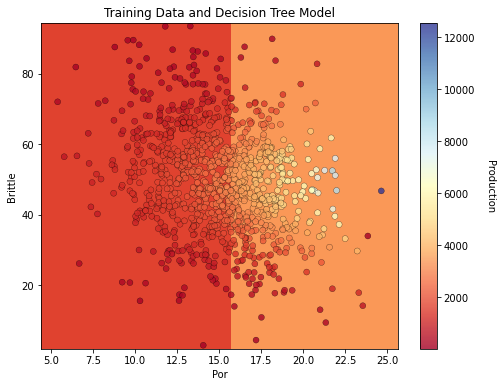

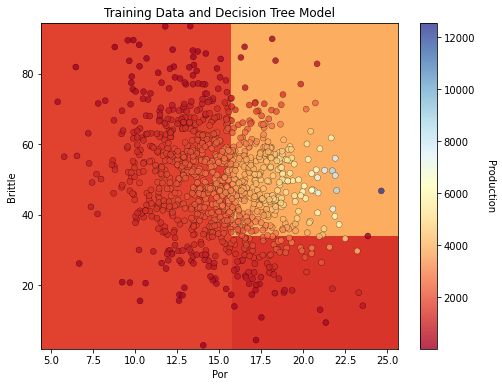

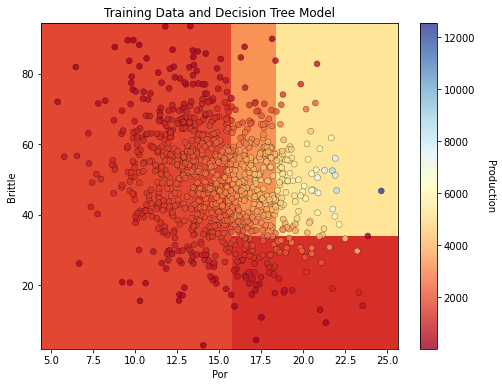

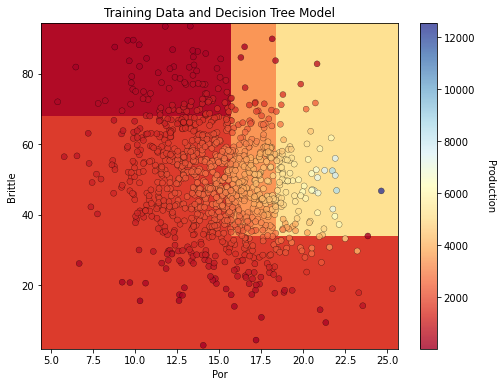

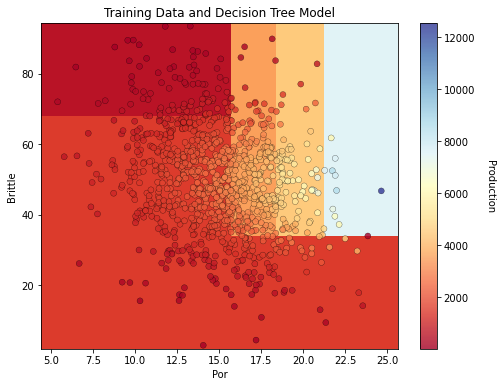

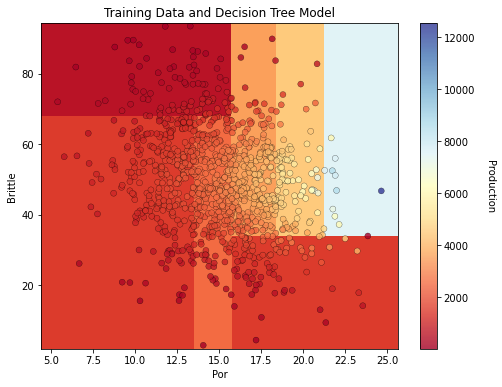

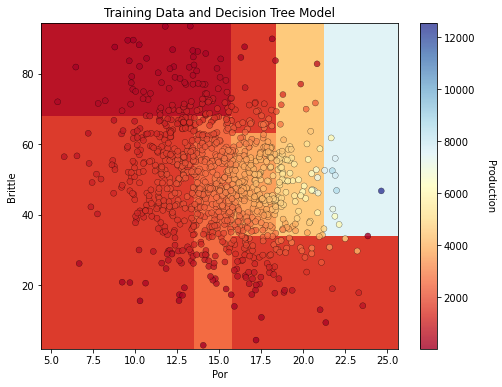

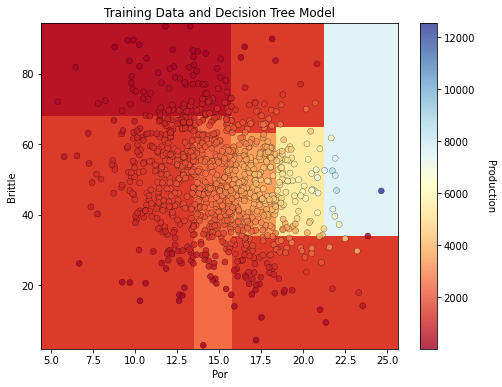

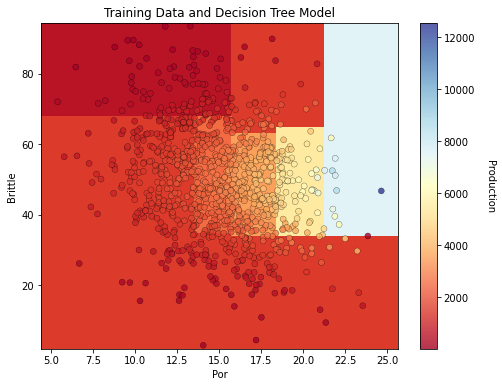

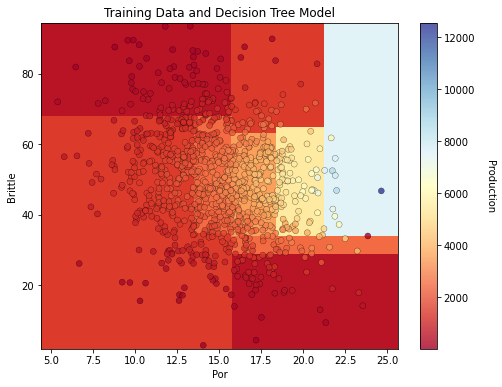

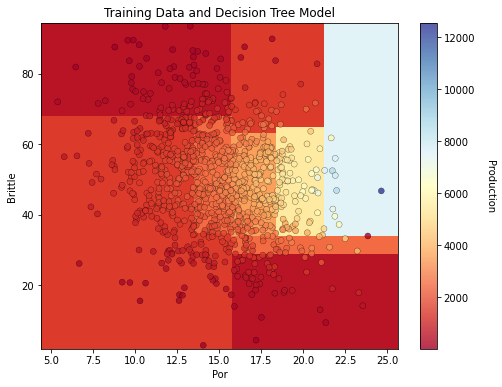

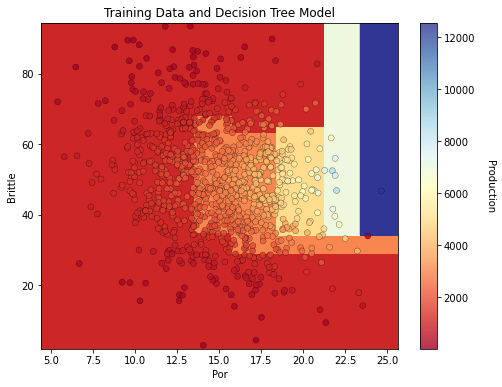

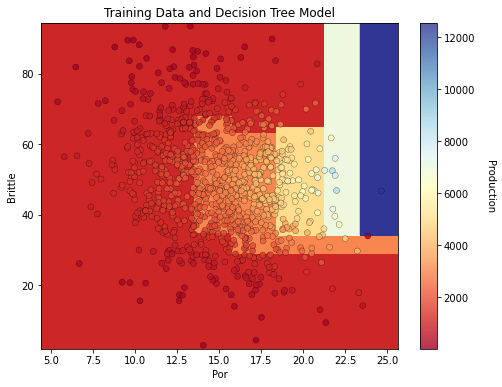

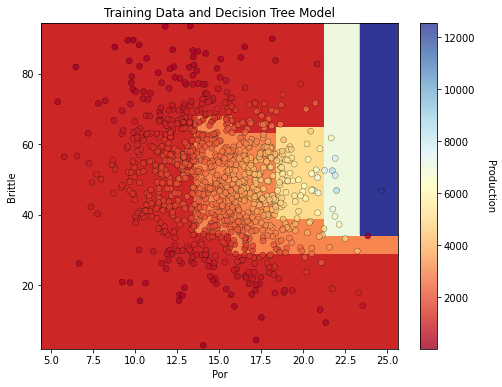

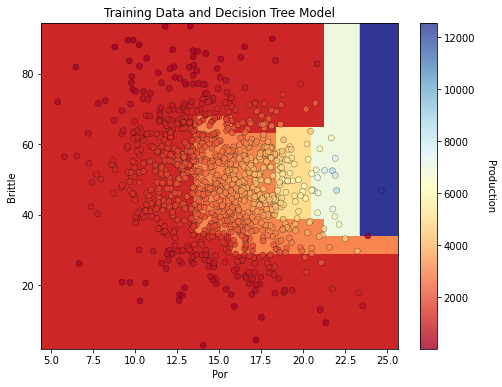

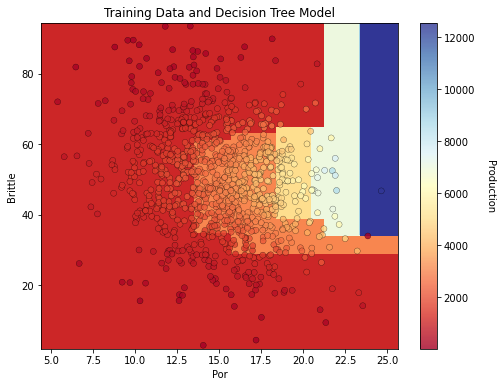

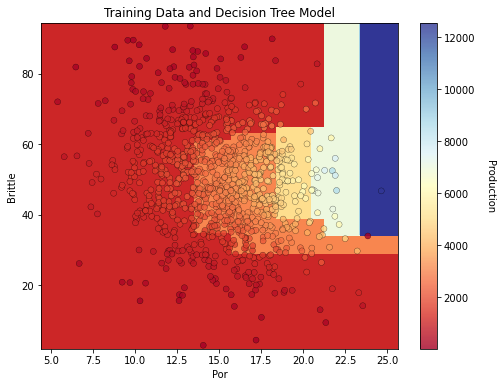

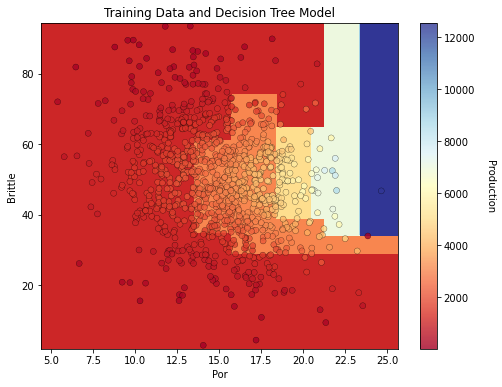

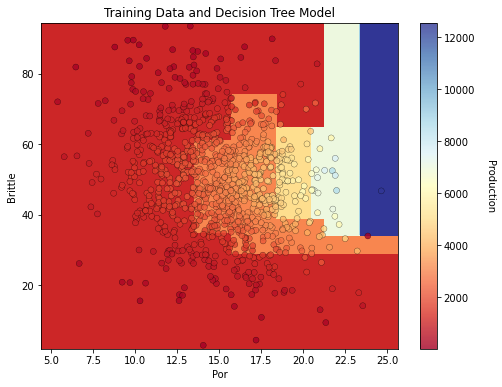

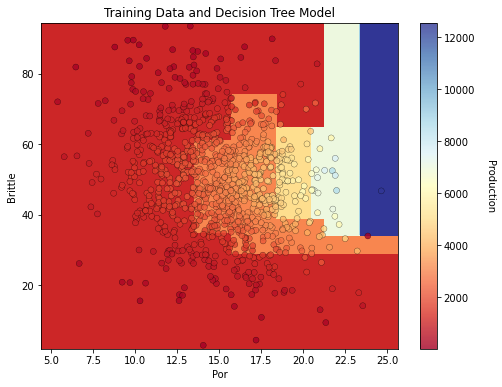

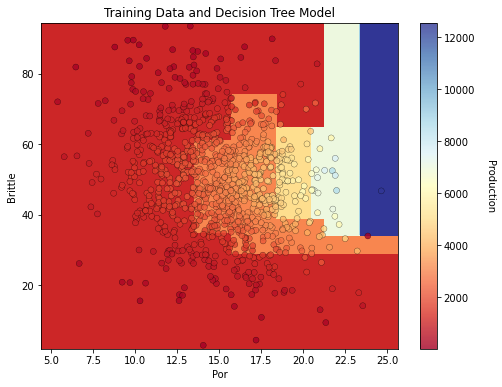

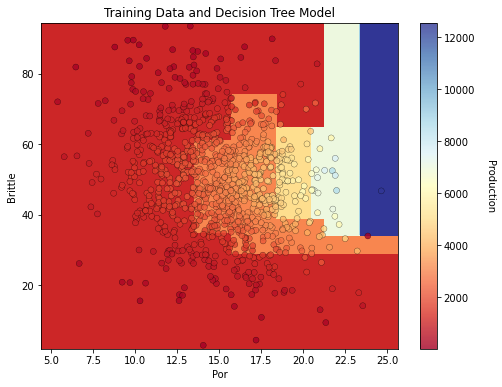

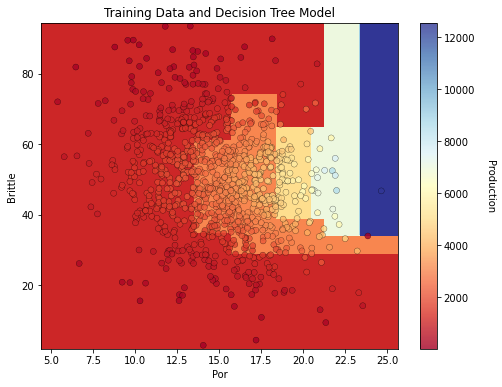

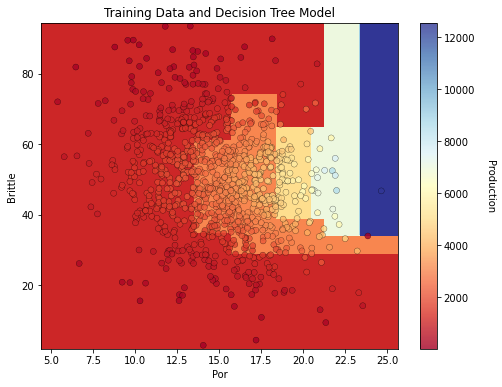

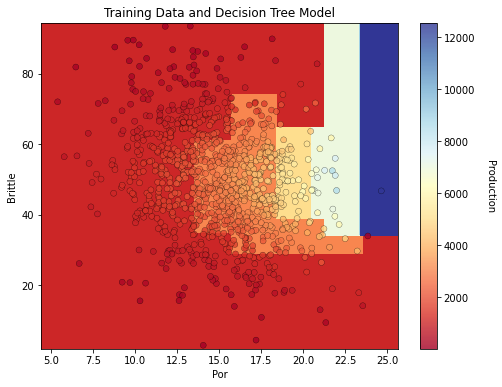

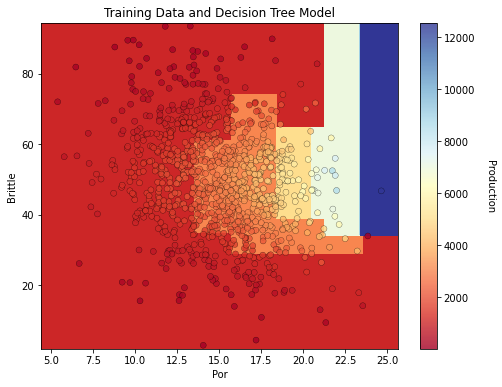

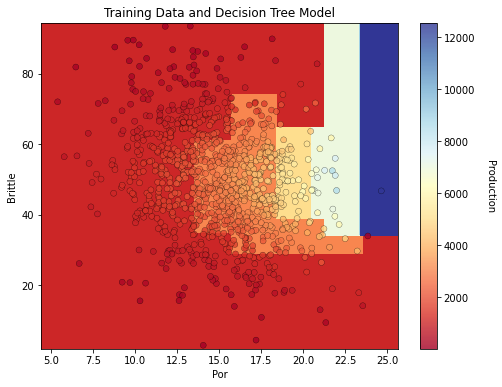

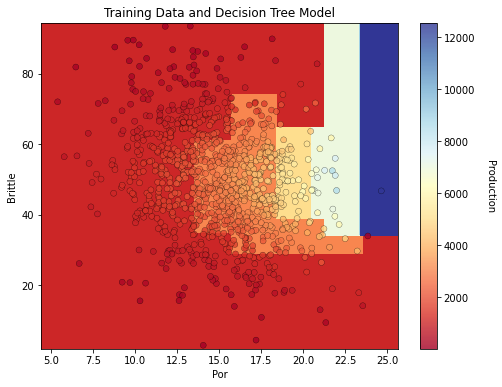

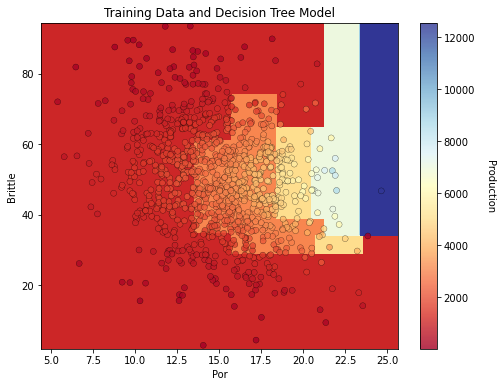

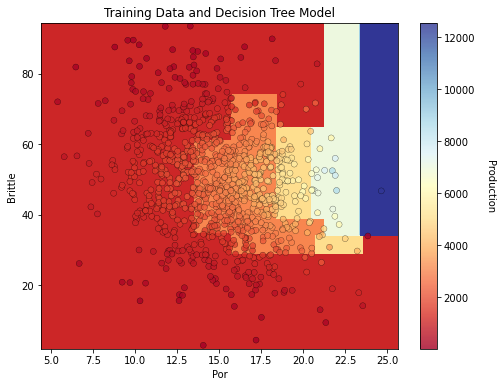

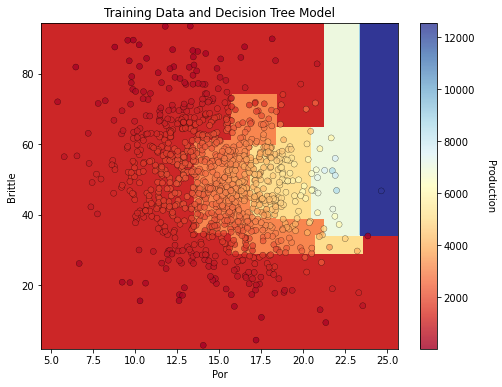

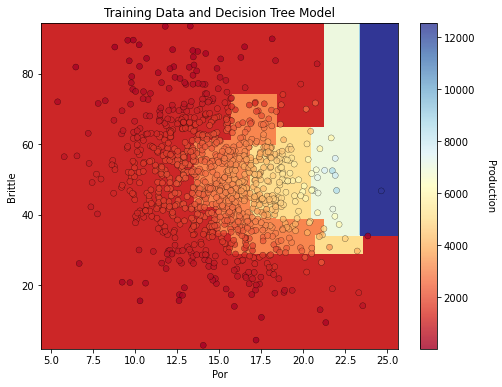

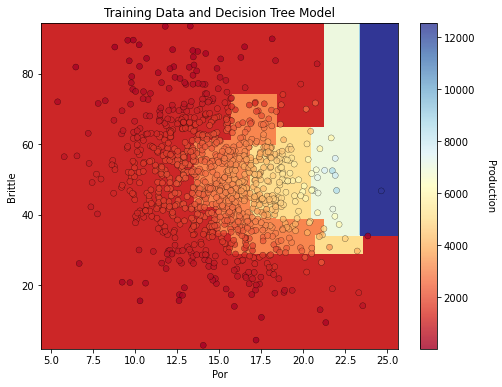

In [45]:
trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
while inodes < 35:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(features, response)
    trees.append(my_tree)
    visualize_tree(my_tree,mydata_3var["Por"],mydata_3var["Brittle"],mydata_3var["Production"],'Training Data and Decision Tree Model')

    predict_train = my_tree.predict(np.c_[mydata_3var["Por"],mydata_3var["Brittle"]])
    
    error.append(metrics.mean_squared_error(mydata_3var["Production"],predict_train))
    var_exp.append(metrics.explained_variance_score(mydata_3var["Production"],predict_train))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1

Let's see how our set of tree models form simple to complicated (with terminal nodes from 3 to 20) performed with an  accuracy measured as mean square error for the training data.

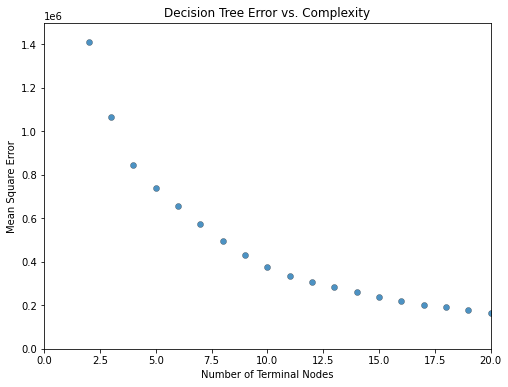

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(nodes,error,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Decision Tree Error vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(0,20); plt.ylim(0,1500000)
plt.show()

It is useful to evaluate the performance of our tree by observing the accuracy vs. complexity trade-off.  Also, it was useful for us to observed the tree model over the feature space as we incrementally add terminal nodes. We can graphically observe the hierarical binary splitting quite clearly.  

Yet, what we really want to do is test our model performance.  We should perform cross validation that does not use the same data to train and to test the model.  sklearn has a built in cross validation method called cross_val_score that we can use to:

1. Apply k-fold approach with iterative separation of training and testing data
2. Automate the model construction, looping over folds and averaging the metric of interest

Let's try it out on our trees with variable number of terminal nodes.  Note the cross validation is set to use 4 processors, but still will likely take a couple of minutes to run.


In [50]:
score = []                    
node = []
for inodes in range(2,50):
    my_tree = tree.DecisionTreeRegressor(max_leaf_nodes=inodes) 
    scores = cross_val_score(estimator=my_tree, X= np.c_[mydata['Por'],mydata['Brittle']],y=mydata['Production'], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    node.append(inodes)

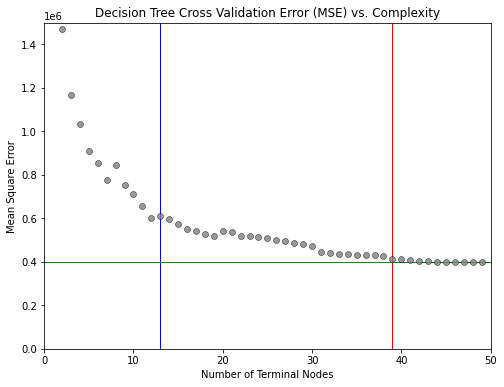

In [54]:
plt.figure(figsize=(8,6))
plt.arrow(39,0,0,1500000,width=0.02,color='red',head_length=0.0,head_width=0.0)
plt.arrow(13,0,0,1500000,width=0.02,color='blue',head_length=0.0,head_width=0.0)
plt.arrow(0,400000,90,0,width=0.02,color='green',head_length=0.0,head_width=0.0)
plt.scatter(node,score,s=None, c="grey", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, edgecolors="black")
plt.title('Decision Tree Cross Validation Error (MSE) vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(0,50); plt.ylim(0,1500000)
plt.show()

It is clear that at about 39 terminal nodes the increase in accuracy with increase in complexity is quite low.  One could select the 39 as the maximum number of terminal node parameter for the tree.  Also, there is an inflection point at about 13 terminal nodes, if the accuracy is sufficent, one could select 13. In addition, there might be required level of accuracy as represented by the green line and we could choose the minimum number of terminal nodes to reach that accuracy.  Let's limit our tree to 13 terminal nodes and visualize it.  

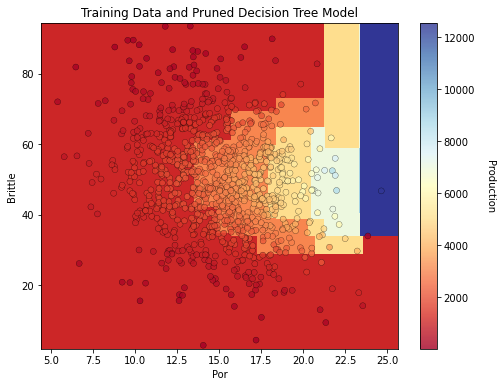

In [55]:
my_pruned_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=12)
my_pruned_tree = my_tree.fit(features, response)

visualize_tree(my_tree,mydata_3var["Por"],mydata_3var["Brittle"],mydata_3var["Production"],'Training Data and Pruned Decision Tree Model')

In [46]:
# We will use random processes, to ensure repeatability between runs let's set the random seed
import random

np.random.seed(0)
random=random.seed(71071)

In [ ]:
np.random.seed(71071)

Insted of using all of our dataset, lets use training and testing approach.

In [58]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeRegressor

X=mydata_3var.drop(columns='Production')
y=mydata_3var['Production']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=500,random_state=71071)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4,min_samples_split=0.01,min_samples_leaf=10)
regr_2 = DecisionTreeRegressor(max_depth=15)

regr_1.fit(X=X_train, y=y_train)
regr_2.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=15)

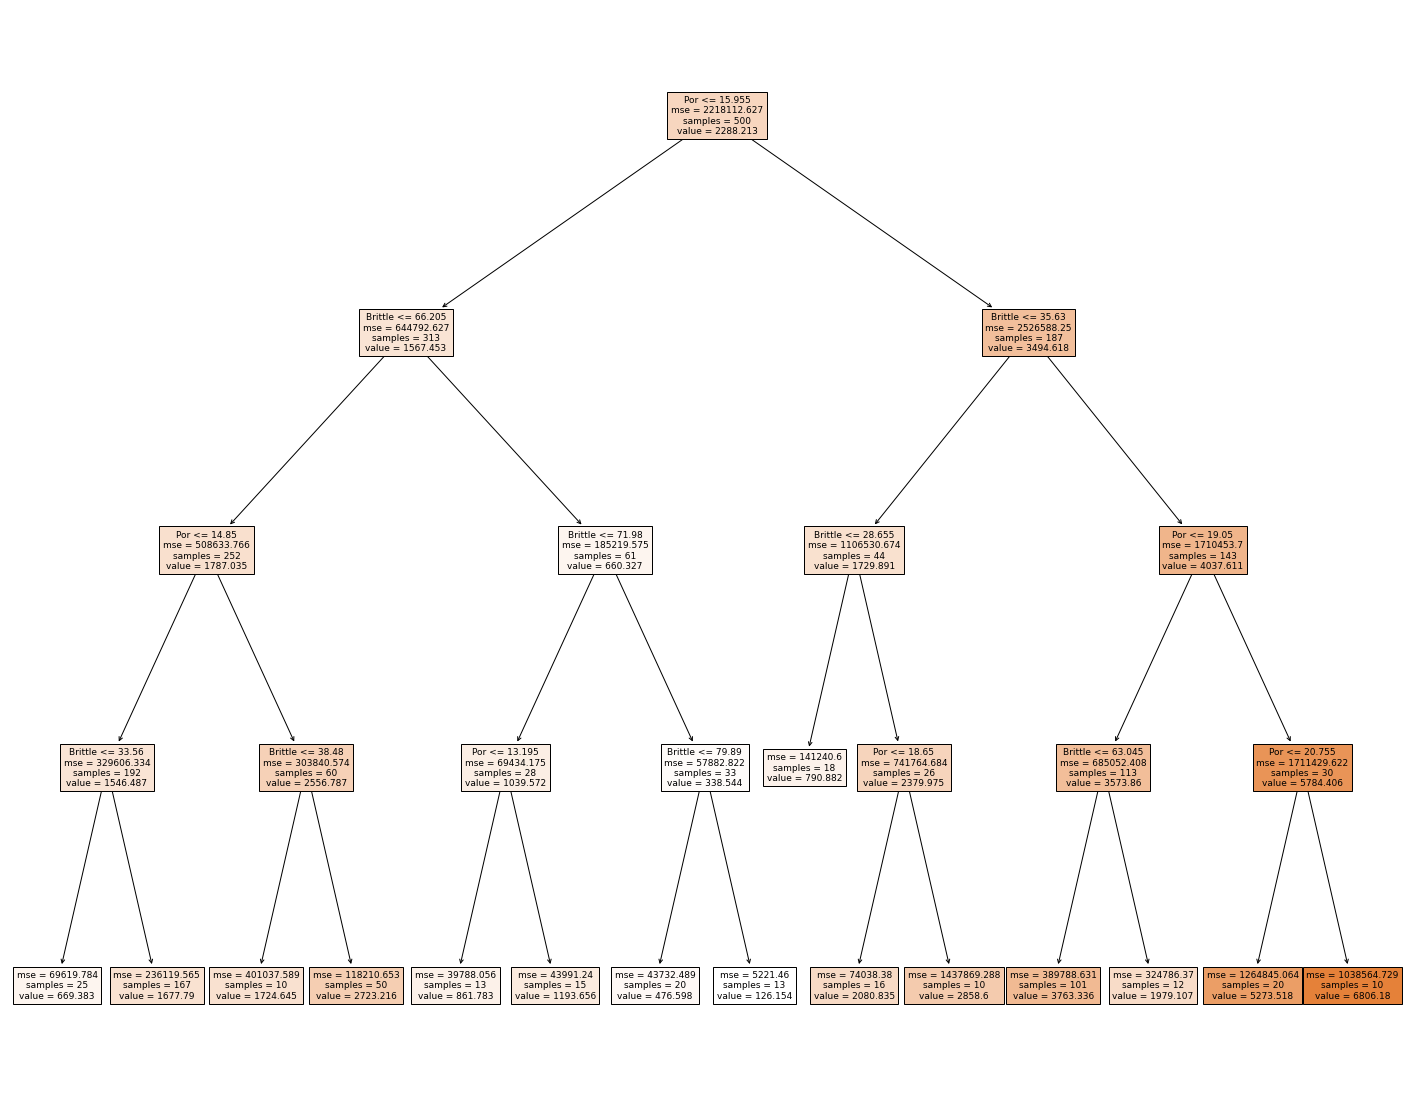

In [59]:
from sklearn import tree
feature_names=['Por','Brittle']

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr_1, 
                   feature_names=feature_names,  
                   filled=True)

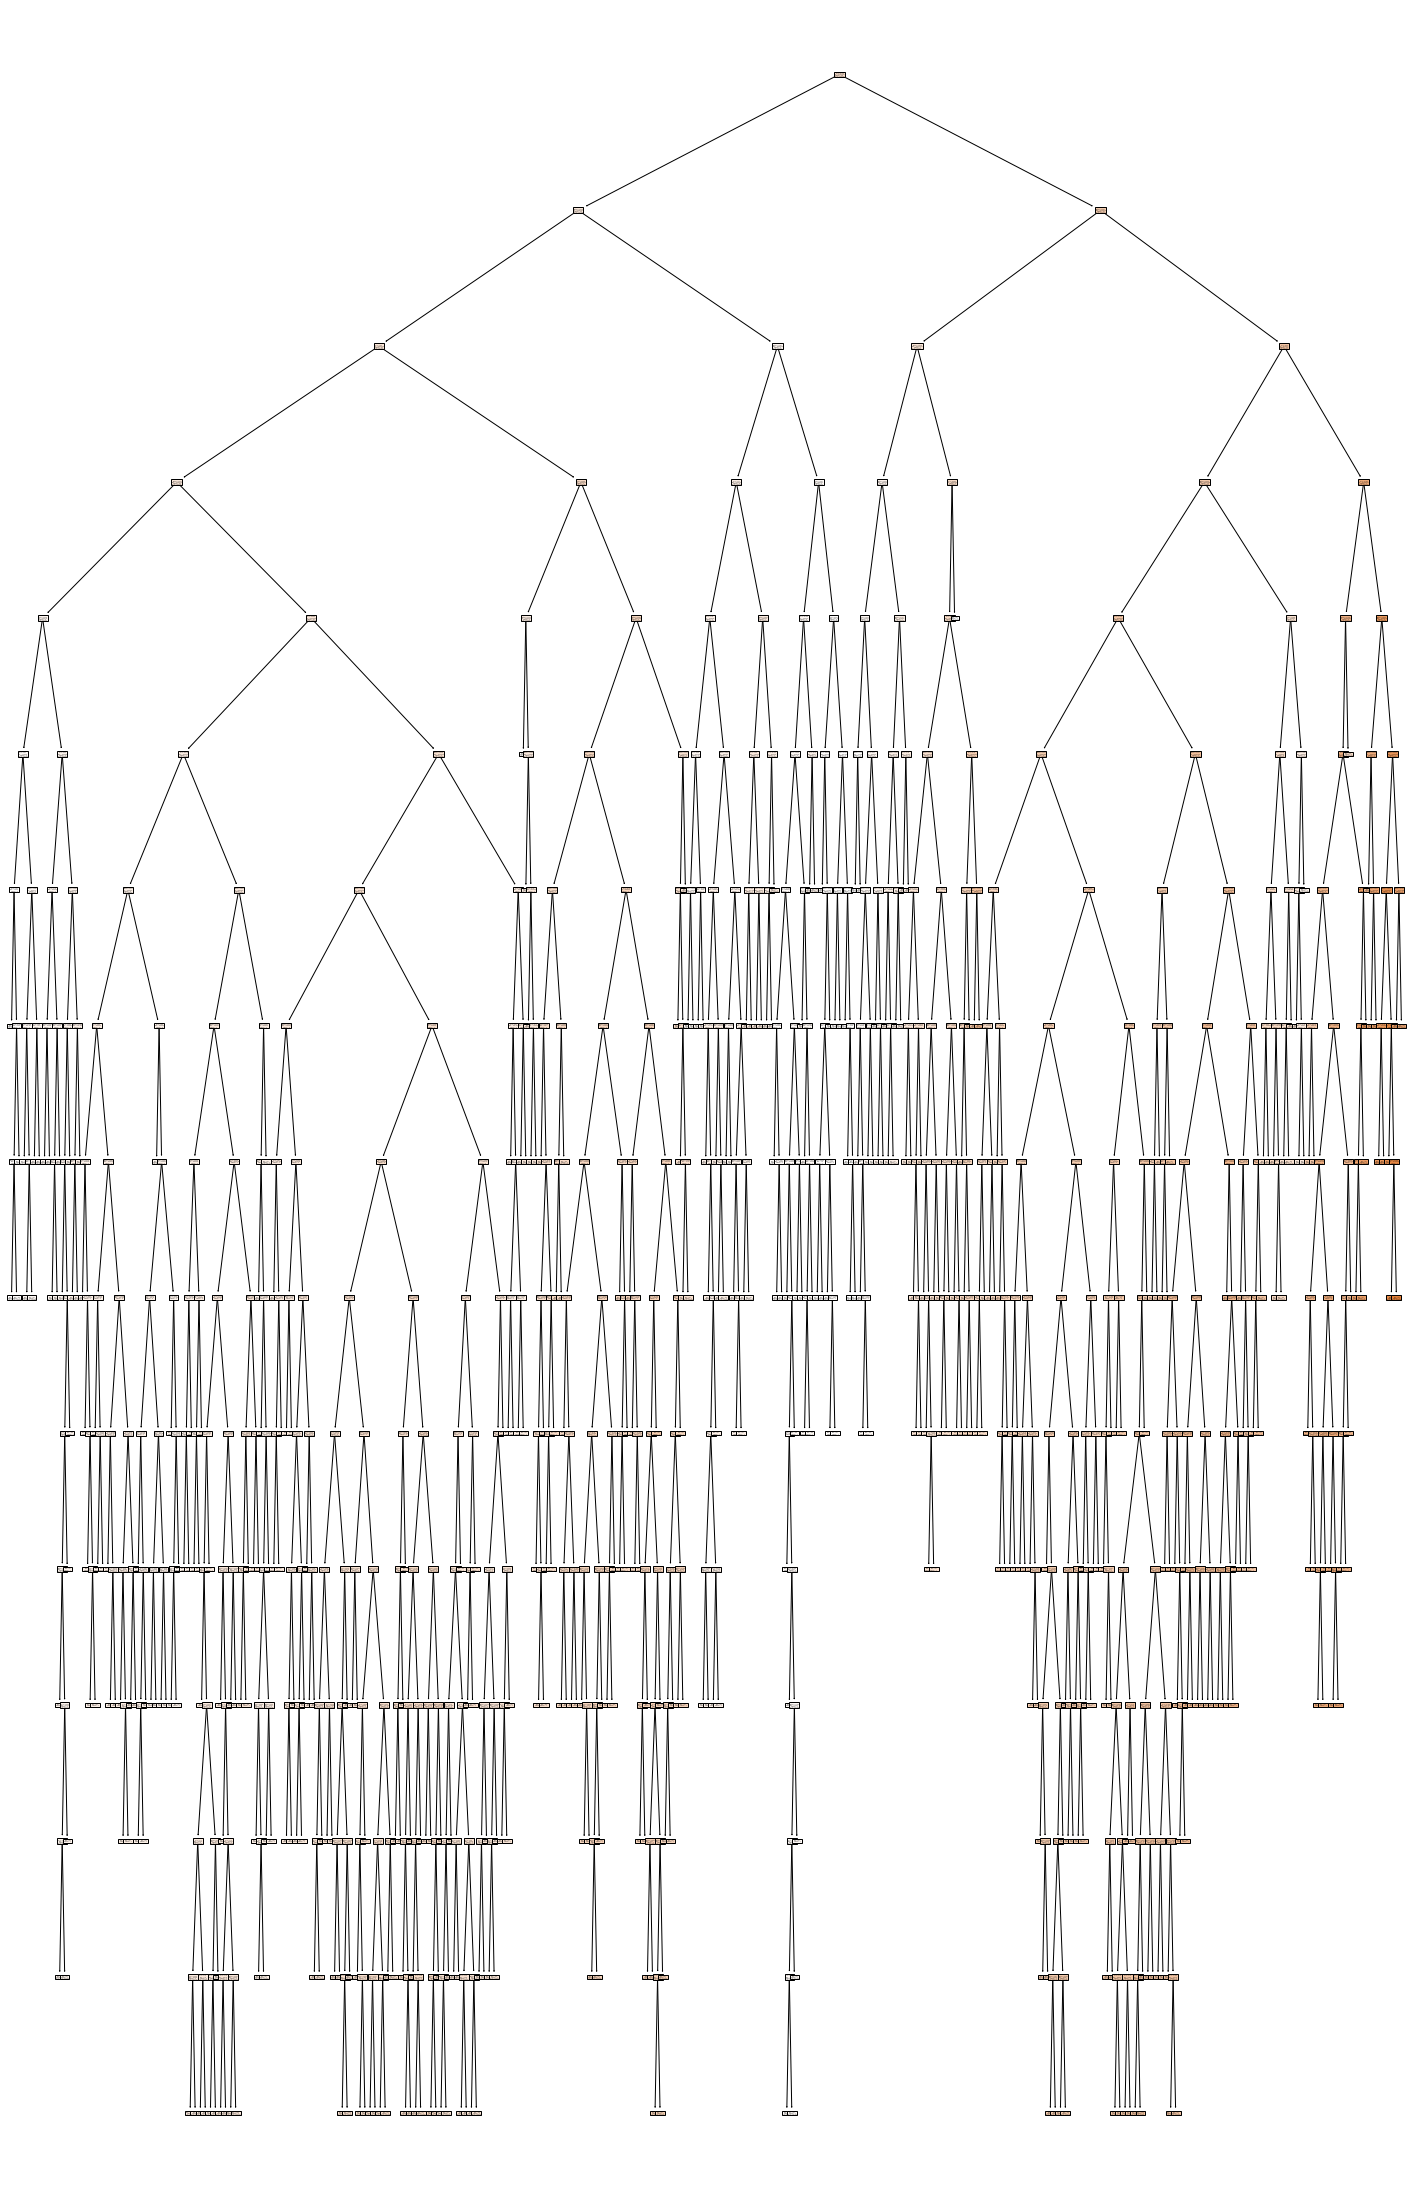

In [60]:
from sklearn import tree
feature_names=['Por','Brittle']

fig = plt.figure(figsize=(25,40))
_ = tree.plot_tree(regr_2, 
                   feature_names=feature_names,  
                   filled=True)

In [61]:
#use a grid search Over a specified range of possible hyperparameters values
parameters={
    'max_depth':range(3,10),
    'min_samples_split':[2,3,4],
    'ccp_alpha':np.arange(0,0.2,10)
}

In [62]:
reg_3=GridSearchCV(tree.DecisionTreeRegressor(),
                  parameters,
                  cv=10,
                  n_jobs=-1)

In [63]:
reg_3.fit(X=X_train, y=y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.]), 'max_depth': range(3, 10),
                         'min_samples_split': [2, 3, 4]})

In [64]:
#extract best CV model and print its accuracy measure
cv_best_model=reg_3.best_estimator_
print("Best CV Accuracy: {}, with parameters: {}".format(reg_3.best_score_,reg_3.best_params_))

Best CV Accuracy: 0.8859342615530522, with parameters: {'ccp_alpha': 0.0, 'max_depth': 9, 'min_samples_split': 2}


In [65]:
# Let's use our trees to make predictions on test data
y_1 = regr_1.predict(X_test)  
y_2 = regr_2.predict(X_test)
y_3=cv_best_model.predict(X_test)

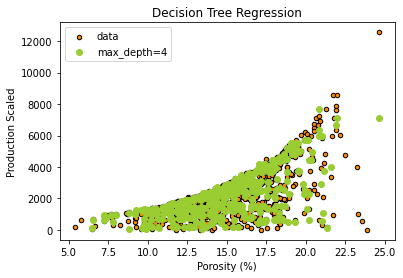

In [66]:
# We can plot the predictions vs. the test data set.
# Plot the results
plt.figure()
plt.scatter(X['Por'], y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.scatter(X_test['Por'], y_2, color="yellowgreen", label="max_depth=15")
plt.xlabel("Porosity (%)")
plt.ylabel("Production Scaled")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

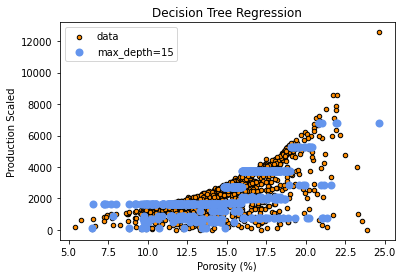

In [67]:
# Plot the results
plt.figure()
plt.scatter(X['Por'], y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.scatter(X_test['Por'], y_1, color="cornflowerblue",
         label="max_depth=1", linewidth=2)
plt.xlabel("Porosity (%)")
plt.ylabel("Production Scaled")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

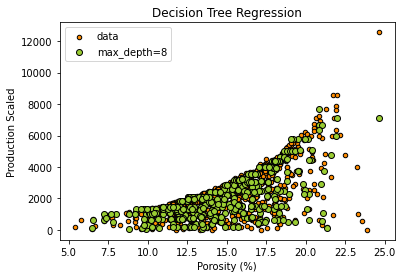

In [68]:
# Plot the results
plt.figure()
plt.scatter(X['Por'], y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.scatter(X_test['Por'], y_3, edgecolor="black",color="yellowgreen", label="max_depth=8")
plt.xlabel("Porosity (%)")
plt.ylabel("Production Scaled")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Define an evaluation function for calculating some helpful metrics
# We can calculate the mean square error and the square root of the MSE for our prediction model.

def evaluate (model, test_features, test_labels):
    predictions=model.predict(test_features)
    r2=r2_score(y_pred=predictions, y_true=test_labels)
    MAE=mean_absolute_error(test_labels, predictions)
    MSE=mean_squared_error(test_labels, predictions)
    rmse = sqrt(MSE)

    print('r2 = {:0.2f}'.format(r2))
    print('MAE = {:0.2f}'.format(MAE))
    print('Mean Square Error = {:0.2f}'.format(MSE))
    print('Squareroot Mean Square Error = {:0.2f}'.format(rmse))

In [70]:
evaluate(cv_best_model,X_test,y_test)

r2 = 0.90
MAE = 203.03
Mean Square Error = 206116.44
Squareroot Mean Square Error = 454.00


In [71]:
evaluate(regr_1,X_test,y_test)

r2 = 0.76
MAE = 458.99
Mean Square Error = 502498.71
Squareroot Mean Square Error = 708.87


In [72]:
evaluate(regr_2,X_test,y_test)

r2 = 0.92
MAE = 173.69
Mean Square Error = 170932.17
Squareroot Mean Square Error = 413.44


### In class excercise
#### On your own try working working with more and less complicated trees.  Also, for improved regression accuracy

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

- max_depth<br>
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.When “None”, it signifies that nodes will be expanded till all leaves are homogeneous. When value assigned Pruning is done. <br>

- max_features<br>
None; All features or independent variables are considered while deciding split of a node #The number of features to consider when looking for the best split<br>

- min_samples_split<br>
int or float, default=2<br>
The minimum number of samples required to split an internal node.
